In [30]:
import sys
import os
os.chdir("C:\\Users\\Zber\\Documents\\Dev_program\\OpenRadar")
import numpy as np
import mmwave.dsp as dsp
import mmwave.dsp.music as music
import mmwave.clustering as clu
from mmwave.dataloader import DCA1000
from demo.visualizer.visualize import ellipse_visualize
from FER.data_processing.mediapipe_facemesh_one import flm_detector, distance
from scipy import signal

from mmwave.dsp.utils import Window
from mmwave.dsp import utils
import math
from FER.utils import parseConfigFile, arange_tx

from itertools import accumulate
from operator import add
from mmwave.dsp.cfar import ca

from scipy.signal import find_peaks, peak_widths
# import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')

from mpl_toolkits.mplot3d import Axes3D

plt.close('all')

DebugMode = True

if not DebugMode:
    import matplotlib

    matplotlib.use('Agg')

# plotting color
import matplotlib._color_data as mcd

tab_color = [mcd.TABLEAU_COLORS[name] for name in mcd.TABLEAU_COLORS]
extra_color = ['#acc2d9', '#56ae57', '#b2996e', '#a8ff04']
tab_color = tab_color + extra_color

# figpath = "C:/Users/Zber/Desktop/mmWave_figure"
figpath = "C:/Users/Zber/Desktop/SavedFigure"
configFileName = 'C:/Users/Zber/Desktop/mmWave Configuration/profile_3d_aop_3s.cfg'

In [32]:
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/OpenEyes_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/OpenMouth_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/RaiseCheek_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/OnlySurprise_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/OnlyBodyMotion_0_Raw_0.bin"
# adc_data_path = "D:\\Subjects\\S2\\Neutral_10_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/Surprise0.5m_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/1m_standing_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/Standing_1_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/empty_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/1m_standing&surprise_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/1m_standing&alwaysmove_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/1m_sit_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/sit_1m_move_1_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/stand_1m_move_1_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/stand_1m_body_move_1_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/stand_1m_body_move_2_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/stand_1m_head_move_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/sit_1m_always_surprise_3_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Distance_1m/Joy_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Distance_100cm/Surprise_0_Raw_0.bin"
# 

adc_data_path = "D:/Subjects/Distance_100cm/Surprise_4_Raw_0.bin"
# adc_data_path = "D:/Subjects/M3_0/Surprise_6_Raw_0.bin"


# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Distance_1m_stand/Joy_1_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Distance_1m/Neutral_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Distance_1m_stand/Joy_2_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Distance_1m_ground/Joy_2_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Multi_People/Joy_3_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Multi_People/Joy_3_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Multi_People_3/Joy_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Distance_1m_ground/Joy_2_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/stand_1m_always_surprise_3_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/1m_ground_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/ground_1m_2_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/sit_1m_3_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/ground_1m_1_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/Surprise1m_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/SurpriseAndBodyMotion_0_Raw_0.bin"
# adc_data_path = "C:/Users/Zber/Desktop/Subjects/Test/1m_standing2ground_0_Raw_0.bin"

In [33]:
# num Antennas
numTxAntennas = 3
numRxAntennas = 4
# load configure parameters
config = parseConfigFile(configFileName)

# mmWave radar settings
numFrames = config['numFrames']
numADCSamples = config['numAdcSamples']
numLoopsPerFrame = config['numLoops']
numChirpsPerFrame = numTxAntennas * numLoopsPerFrame
numAngleBins = 64

# aoa related
VIRT_ELE_PAIRS = [[8, 2], [9, 3], [10, 4], [11, 5]]
VIRT_AZI_PAIRS = [[i for i in range(0, 8)]]

# azimuth
ANGLE_RES_AZI = 1
ANGLE_RANGE_AZI = 90
ANGLE_BINS_AZI = (ANGLE_RANGE_AZI * 2) // ANGLE_RES_AZI + 1
VIRT_ANT_AZI = 8

# elevation
ANGLE_RES_ELE = 1
ANGLE_RANGE_ELE = 30
ANGLE_BINS_ELE = (ANGLE_RANGE_ELE * 2) // ANGLE_RES_ELE + 1
VIRT_ANT_ELE = 2

BIN_RANG_S = 0
BIN_RANG_E = 256
BINS_PROCESSED = BIN_RANG_E - BIN_RANG_S
VIRT_ANT_AZI_INDEX = [i for i in range(0, 8)]
VIRT_ANT_ELE_INDEX = VIRT_ELE_PAIRS[2]

# data processing parameter
range_resolution, bandwidth = dsp.range_resolution(config['numAdcSamples'],
                                                    dig_out_sample_rate=config['digOutSampleRate'],
                                                    freq_slope_const=config['freqSlopeConst'])

doppler_resolution = dsp.doppler_resolution(bandwidth, start_freq_const=config['startFreq'],
                                            ramp_end_time=config['rampEndTime'],
                                            idle_time_const=config['idleTime'],
                                            num_loops_per_frame=config['numLoops'],
                                            num_tx_antennas=numTxAntennas)

print('Range Resolution: {:.2f}cm, Bandwidth: {:.2f}Ghz, Doppler Resolution: {:.2f}m/s'.format(
    range_resolution * 100, bandwidth / 1000000000, doppler_resolution))


Range Resolution: 4.22cm, Bandwidth: 3.56Ghz, Doppler Resolution: 0.43m/s


In [34]:
# Reading in adc data
adc_data = np.fromfile(adc_data_path, dtype=np.int16)
adc_data = adc_data.reshape(numFrames, -1)
adc_data = np.apply_along_axis(DCA1000.organize_cli, 1, adc_data, num_chirps=numChirpsPerFrame,
                                num_rx=numRxAntennas, num_samples=numADCSamples)
print("Data Loaded!")

# processing range data
# window types : Bartlett, Blackman p, Hanning p and Hamming
# range_data = dsp.range_processing(adc_data)
range_data = dsp.range_processing(adc_data, window_type_1d=Window.HANNING)
range_data = arange_tx(range_data, num_tx=numTxAntennas)

Data Loaded!


(300, 32, 12, 256)


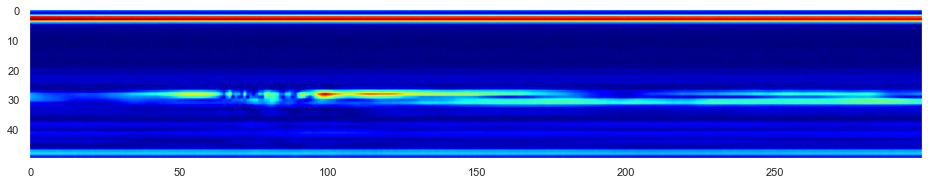

In [35]:
# range profile
print(range_data.shape)
fig5, axes5 = plt.subplots(1, 1, figsize=(16, 9))
range_plot_data = np.mean(range_data[:,15,:,:50],axis=(1))
# range_plot_data = np.mean(range_data,axis=(1,2))
# range_plot_data = range_data[:,15,2,:50]
axes5.imshow(np.abs(range_plot_data.T), cmap=plt.get_cmap('jet'))

# range doppler processing


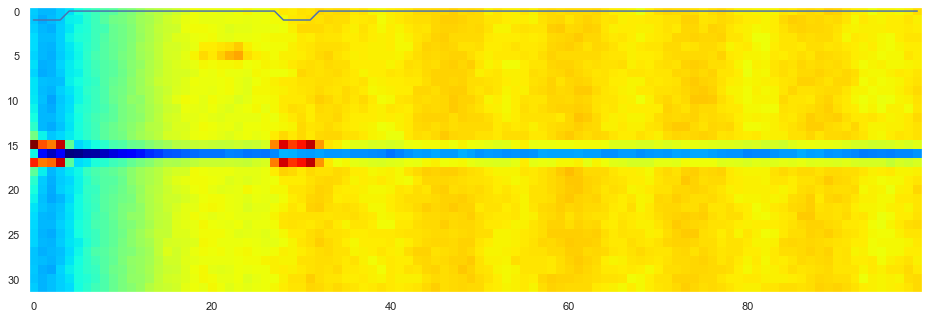

In [36]:
# %matplotlib widget
s_bin = 0
e_bin = s_bin + 100
# %matplotlib inline
fig, axes = plt.subplots(1, 1, figsize=(16, 9))
det_matrix, aoa_input = dsp.doppler_processing_frame(range_data, num_tx_antennas=numTxAntennas,
                                                    clutter_removal_enabled=True,
                                                    window_type_2d=Window.HAMMING,
                                                    accumulate=True)

# det_matrix, aoa_input = doppler_processing(range_data, num_tx_antennas=numTxAntennas,
#                                                     clutter_removal_enabled=True,
#                                                     window_type_2d=Window.HAMMING,
#                                                     accumulate=True)

det_matrix_vis = np.fft.fftshift(det_matrix, axes=2)
det_matrix_vis_mean = np.mean(det_matrix_vis[:, :, :], axis=0)
# det_matrix_vis_mean = np.mean(det_matrix_vis[50:100, :, :], axis=0)
bin_data = det_matrix_vis_mean[:, 17] + det_matrix_vis_mean[:, 15]

peak_data = ca(bin_data, guard_len=2, noise_len=4, l_bound=8)[s_bin:e_bin]

axes.plot(peak_data)
# axes.axvline(x=20, color='r', linestyle='-')
# axes.axvline(x=24, color='r', linestyle='-')

axes.imshow(np.abs(det_matrix_vis_mean.T[:,s_bin:e_bin]), cmap=plt.get_cmap('jet'))



In [37]:
det_matrix_vis.shape
offset = 5
peak_data = peak_data[offset:offset+200]
detect_pos = np.where(peak_data == True)[0]
detect_pos += offset
print(detect_pos)

[28 29 30 31]


In [38]:
# bin_start = detect_pos[0]
# bin_end = detect_pos[-4]

# bin_start = detect_pos[0]
# bin_end = detect_pos[-1]

bin_start = 29
bin_end = 32

print("start {}, end {}".format(bin_start, bin_end))
num_vec_azi, steering_vec_azi = dsp.gen_steering_vec(ANGLE_RANGE_AZI, ANGLE_RES_AZI, VIRT_ANT_AZI)
num_vec_ele, steering_vec_ele = dsp.gen_steering_vec(ANGLE_RANGE_ELE, ANGLE_RES_ELE, VIRT_ANT_ELE)

start 29, end 32


In [39]:
print(aoa_input.shape)
aoa_input = np.transpose(aoa_input, (0,3,2,1))
print(aoa_input.shape)

(300, 256, 12, 32)
(300, 32, 12, 256)


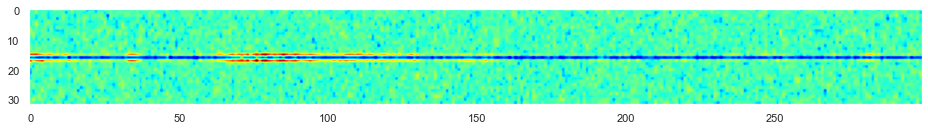

In [40]:
#micro doppler plot
# d_start = 8
# d_end = 11

d_start = bin_start
d_end = bin_end + 1

fig3, axes3 = plt.subplots(1, 1, figsize=(16, 9))
det_matrix_vis_mean = np.mean(det_matrix_vis[:, d_start:d_end, :], axis=1)
axes3.imshow(np.abs(det_matrix_vis_mean.T), cmap=plt.cm.jet)


In [41]:
# capon processing
num_bins = bin_end-bin_start
npy_azi = np.zeros((numFrames, ANGLE_BINS_AZI, num_bins))
npy_ele = np.zeros((numFrames, ANGLE_BINS_ELE, num_bins))
for i in range(0, 300):
    rb = 0
    for r in range(bin_start, bin_end):
        chirp_data_azi= aoa_input[i, :, VIRT_ANT_AZI_INDEX, r]
        # capon beamformer
        capon_angle_azi, beamWeights_azi = dsp.aoa_capon(chirp_data_azi, steering_vec_azi, magnitude=True)
        npy_azi[i, : , rb] = capon_angle_azi

        chirp_data_ele= aoa_input[i, :, VIRT_ANT_ELE_INDEX, r]
        # capon beamformer
        capon_angle_ele, beamWeights_ele = dsp.aoa_capon(chirp_data_ele, steering_vec_ele, magnitude=True)
        npy_ele[i, : , rb] = capon_angle_ele

        rb += 1

In [42]:
# capon processing
ar_sb = 0
ar_eb = 40

# ar_sb = 20
# ar_eb = 30

num_bins = ar_eb - ar_sb
ar_npy_azi = np.zeros((numFrames, ANGLE_BINS_AZI, num_bins))
ar_npy_ele = np.zeros((numFrames, ANGLE_BINS_ELE, num_bins))
for i in range(0, 300):
    rb = 0
    for r in range(ar_sb, ar_eb):
        chirp_data_azi= range_data[i, :, VIRT_ANT_AZI_INDEX, r]
        # capon beamformer
        # capon_angle_azi, beamWeights_azi = dsp.aoa_capon(chirp_data_azi, steering_vec_azi, magnitude=True)
        capon_angle_azi = music.aoa_music_1D(steering_vec_azi, chirp_data_azi, 1)
        ar_npy_azi[i, : , rb] = capon_angle_azi

        chirp_data_ele= range_data[i, :, VIRT_ANT_ELE_INDEX, r]
        # capon beamformer
        # capon_angle_ele, beamWeights_ele = dsp.aoa_capon(chirp_data_ele, steering_vec_ele, magnitude=True)
        capon_angle_ele = music.aoa_music_1D(steering_vec_ele, chirp_data_ele, 1)

        ar_npy_ele[i, : , rb] = capon_angle_ele
        rb += 1

In [43]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('hot')
new_cmap = truncate_colormap(cmap, 0.0, 0.5)


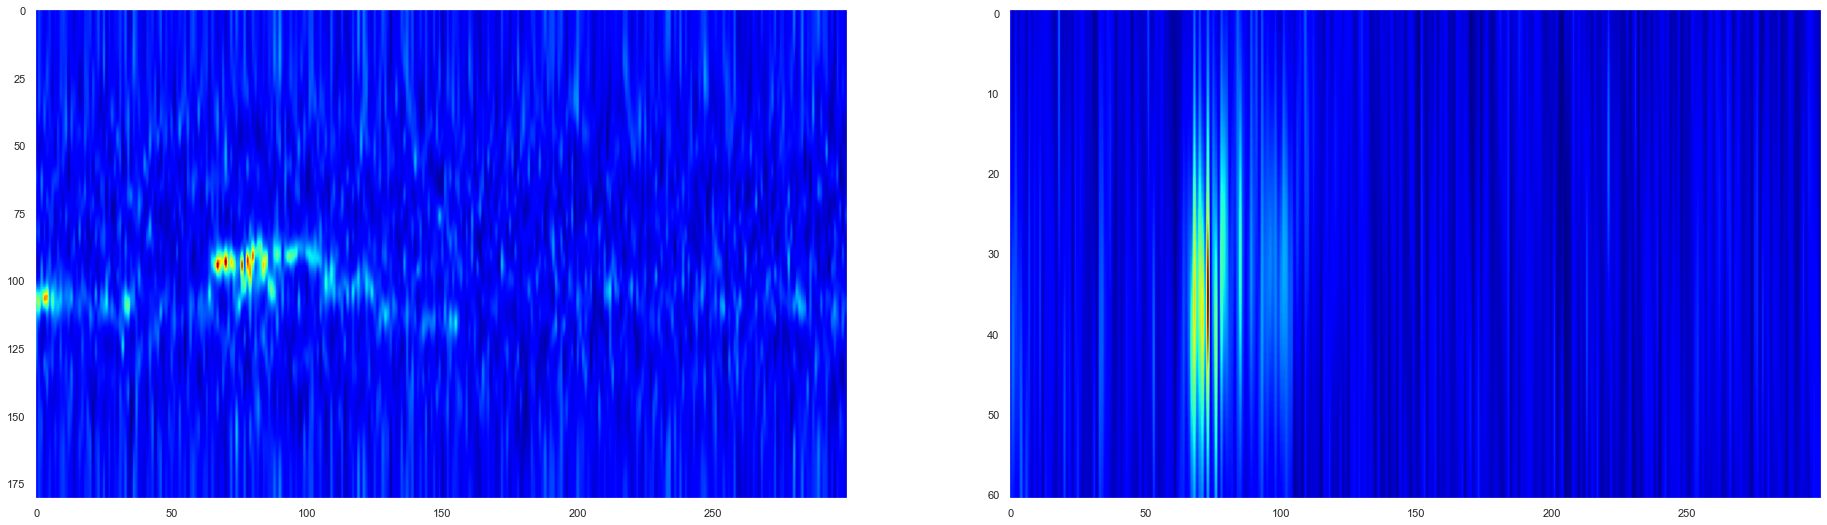

In [44]:
fig1, axes1 = plt.subplots(1, 2, figsize=(32, 9))
axes1[0].imshow(np.mean(npy_azi, 2).T, cmap=plt.cm.jet, aspect='auto')
axes1[1].imshow(np.mean(npy_ele, 2).T, cmap=plt.cm.jet, aspect='auto')

# axes1[0].imshow(np.log10(np.mean(npy_azi, 2).T+1), cmap=plt.cm.jet, aspect='auto')
# axes1[1].imshow(np.log10(np.mean(npy_ele, 2).T+1), cmap=plt.cm.jet, aspect='auto')

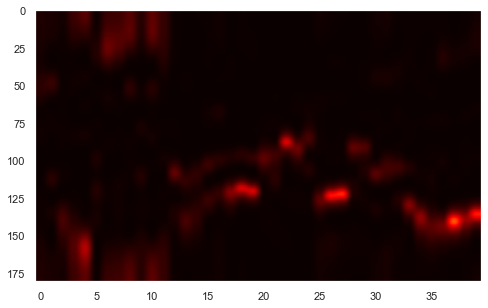

In [46]:
fig2, axes2 = plt.subplots(1, 1, figsize=(8, 5))
# ss, ee = 50, 70

# sub 1
ss, ee = 70, 90
# ar_npy_ele = 20 * np.log10(ar_npy_ele + 1)

# axes2.imshow(ar_npy_azi[f_num], cmap=plt.cm.jet, aspect='auto')
# axes2.imshow(np.mean(ar_npy_azi[ss:ee], axis=0)-np.mean(ar_npy_azi[0:f_num], axis=0), cmap=plt.cm.jet, aspect='auto')

# axes2.imshow(np.mean(ar_npy_azi[ss:ee], axis=0)-np.mean(ar_npy_azi[0:f_num], axis=0), cmap=plt.cm.hot, aspect='auto')


# axes2.imshow(ar_npy_azi[ee], cmap=plt.cm.jet, aspect='auto')
axes2.imshow(ar_npy_azi[ee], cmap=new_cmap, aspect='auto')

# axes2[1].imshow(ar_npy_ele[f_num], cmap=plt.cm.jet, aspect='auto')

# axes2[0].imshow(np.mean(ar_npy_azi[30:70], axis=0), cmap=plt.cm.jet, aspect='auto')
# axes2[1].imshow(np.mean(ar_npy_ele[30:70], axis=0), cmap=plt.cm.jet, aspect='auto')

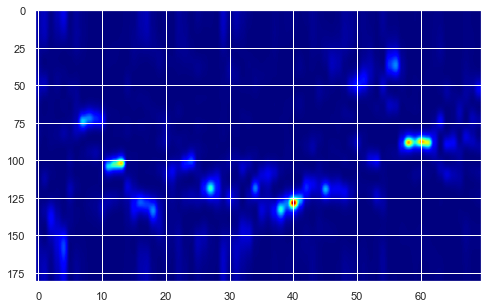

In [123]:
fig3, axes3 = plt.subplots(1, 1, figsize=(8, 5))
f_num = 30
# ar_npy_azi = 20 * np.log10(ar_npy_azi + 1)
# ar_npy_ele = 20 * np.log10(ar_npy_ele + 1)

axes3.imshow(np.mean(ar_npy_azi[0:f_num], axis=0), cmap=plt.cm.jet, aspect='auto')

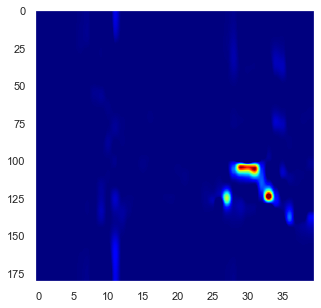

In [28]:
fig4, axes4 = plt.subplots(1, 1, figsize=(5, 5))
# ss, ee = 50, 70

# sub 1
ss, ee = 70, 90
fs = 30
axes4.imshow(ar_npy_azi[ee] - ar_npy_azi[fs], cmap=plt.cm.jet, vmin=0.0, vmax=0.5, aspect='auto')
# axes4.imshow(ar_npy_azi[ee] - ar_npy_azi[fs], cmap=plt.cm.jet,aspect='auto')

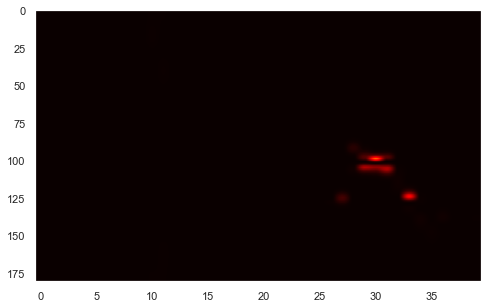

In [29]:
fig5, axes5 = plt.subplots(1, 1, figsize=(8, 5))
data = (ar_npy_azi[ee] - ar_npy_azi[fs])**2
# plot_data = (data - np.mean(data))/np.max(data)

# axes5.imshow(norm_data**2, cmap=plt.cm.jet,aspect='auto')
axes5.imshow(data, cmap=new_cmap, aspect='auto')
# axes5.imshow(data, cmap=plt.cm.jet,aspect='auto')

In [182]:
np.min(plot_data)

0.0

In [107]:
np.max(ar_npy_azi)

2.448529516681344

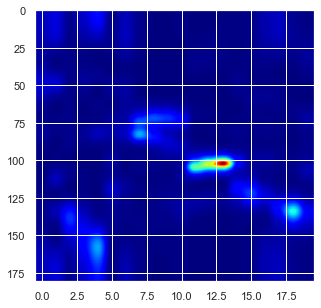

In [25]:
fig5, axes5 = plt.subplots(1, 1, figsize=(5, 5))
# ss, ee = 50, 70

# sub 1
ss, ee = 70, 90
fs = 30
axes5.imshow(np.mean(ar_npy_azi[30:130], axis=0), cmap=plt.cm.jet, aspect='auto')

In [18]:
aoa_input = np.fft.fftshift(aoa_input, axes=1)
num_angle_bins = 120

range_angle = np.zeros((300, num_angle_bins, 256))

for i in range(len(aoa_input)):
    range_doppler = aoa_input[i]
    padding = ((0,0), (0,num_angle_bins-range_doppler.shape[1]), (0,0))
    range_azimuth = np.pad(range_doppler, padding, mode='constant')
    range_azimuth = np.fft.fft(range_azimuth, axis=1)
    range_azimuth = np.log(np.abs(range_azimuth).sum(0))
    range_angle[i] = range_azimuth

In [222]:

print(pos)
print(txt)

[  0.5         13.72222222  26.94444444  40.16666667  53.38888889
  66.61111111  79.83333333  93.05555556 106.27777778 119.5       ]
[-90 -70 -50 -30 -10  10  30  50  70  90]


In [23]:
mm = [29.069444444444446-35, 40.34722222222222-35]

In [24]:
mm

[-5.930555555555554, 5.347222222222221]

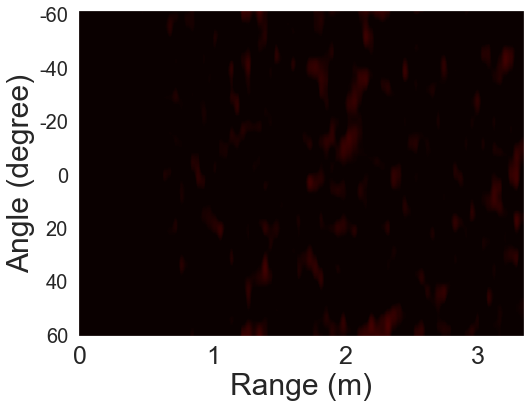

In [55]:
plt.rcParams["axes.grid"] = False
fig7, axes7 = plt.subplots(1, 1, figsize=(8, 6))
f_num = 30
unit = 0.042158314406249994

ss = 30

m_s = [25+29.069444444444446, 25+40.34722222222222]


range_angle_s = np.square(range_angle[:,:,:80])

# pp_data = range_angle_s[ss:ss+100].mean(axis=0)
pp_data = range_angle_s[ss+20]
plot_data = (pp_data- np.min(pp_data))/np.max(pp_data)
# plot_data = (range_angle_s[ss] - np.min(range_angle_s[ss]))/np.max(range_angle_s[ss])
# axes6.imshow(np.mean(range_angle[0:f_num,:,:20], axis=0), cmap=plt.cm.jet, aspect='auto')
# axes7.imshow(range_angle_s[ee], cmap=plt.cm.hot, vmin=0.0, vmax=0.8, aspect='auto')
pos = np.linspace(1,119,7)
# pos_1 = (1+ 119)/2
# pos = pos + [pos_1]
# txt_1 = 0
txt = np.arange(-60, 61, step=20)
# txt = txt + txt_1
axes7.set_yticks(pos)
axes7.set_yticklabels(txt,fontsize=20)
max_range = range_angle_s.shape[2]
xpos_label = np.arange(0,4, step=1)
xpos = xpos_label/unit
axes7.set_xticks(xpos)
axes7.set_xticklabels(xpos_label,fontsize=25)
# axes7.axhline(m_s[0],lw=2)
# axes7.axhline(m_s[1],lw=2)

axes7.set_ylabel("Angle (degree)",fontsize=30)

axes7.set_xlabel("Range (m)",fontsize=30)
axes7.imshow(plot_data, cmap=plt.cm.hot, vmin=0.17, vmax=0.7, aspect='auto')
# axes7.imshow(plot_data, cmap=new_cmap, aspect='auto')

# fig7.savefig('C:/Users/Zber/Desktop/mmEmo_Exp/0.Method/angleFFT_heatmap.pdf',format='pdf', bbox_inches="tight")
# fig7.savefig('C:/Users/Zber/Desktop/mmEmo_Exp/0.Method/angleFFT_heatmap_line.svg',format='svg', bbox_inches="tight")
# fig7.savefig('C:/Users/Zber/Desktop/mmEmo_Exp/0.Method/angleFFT_heatmap.svg',format='svg', bbox_inches="tight")



# axes6.imshow(range_angle_s[ee]-range_angle_s[ss], cmap=plt.cm.jet, aspect='auto')

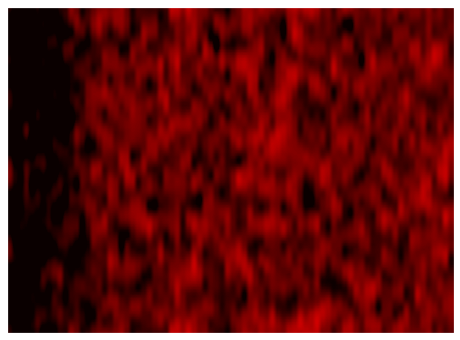

In [26]:
plt.rcParams["axes.grid"] = False
fig7, axes7 = plt.subplots(1, 1, figsize=(8, 6))
f_num = 30
unit = 0.042158314406249994

ss = 30

m_s = [25+29.069444444444446, 25+40.34722222222222]


range_angle_s = np.square(range_angle[:,:,:80])
pp_data = range_angle_s[ss+20]
plot_data = (pp_data- np.min(pp_data))/np.max(pp_data)

axes7.imshow(plot_data, cmap=plt.cm.hot, vmin=0.1, vmax=0.5, aspect='auto')
axes7.set_xticks([])
axes7.set_yticks([])
fig7.savefig('C:/Users/Zber/Desktop/mmEmo_Exp/0.Method/init_heatmap.svg',format='svg', bbox_inches="tight")



In [237]:
calculate = 80 * unit
sunit = calculate/80

In [243]:
a = np.arange(0,4, step=unit)

1/unit

23.72011343631304

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [240]:
x_pos = [26 ,]

array([0.        , 0.04215831, 0.08431663, 0.12647494, 0.16863326,
       0.21079157, 0.25294989, 0.2951082 , 0.33726652, 0.37942483,
       0.42158314, 0.46374146, 0.50589977, 0.54805809, 0.5902164 ,
       0.63237472, 0.67453303, 0.71669134, 0.75884966, 0.80100797,
       0.84316629, 0.8853246 , 0.92748292, 0.96964123, 1.01179955,
       1.05395786, 1.09611617, 1.13827449, 1.1804328 , 1.22259112,
       1.26474943, 1.30690775, 1.34906606, 1.39122438, 1.43338269,
       1.475541  , 1.51769932, 1.55985763, 1.60201595, 1.64417426,
       1.68633258, 1.72849089, 1.77064921, 1.81280752, 1.85496583,
       1.89712415, 1.93928246, 1.98144078, 2.02359909, 2.06575741,
       2.10791572, 2.15007403, 2.19223235, 2.23439066, 2.27654898,
       2.31870729, 2.36086561, 2.40302392, 2.44518224, 2.48734055,
       2.52949886, 2.57165718, 2.61381549, 2.65597381, 2.69813212,
       2.74029044, 2.78244875, 2.82460707, 2.86676538, 2.90892369,
       2.95108201, 2.99324032, 3.03539864, 3.07755695, 3.11971

In [225]:
xtickslocs = axes7.get_xticks()

In [228]:
xtickslabels = axes7.get_xticklabels()
xtickslabels

[Text(-10.0, 0, '−10'),
 Text(0.0, 0, '0'),
 Text(10.0, 0, '10'),
 Text(20.0, 0, '20'),
 Text(30.0, 0, '30'),
 Text(40.0, 0, '40'),
 Text(50.0, 0, '50'),
 Text(60.0, 0, '60'),
 Text(70.0, 0, '70'),
 Text(80.0, 0, '80')]

In [230]:
range_angle_s.shape[2]

80